# Portfolio Optimization using Deep Reinforcement Learning
---

## 5.0 Feature Reduction
---

Autoencoders are used to reduce the number of technical indicators to be represented by only two features

### 5.1 Import Relevant Libraries

In [155]:
pip install finrl

  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /private/var/folders/3z/6b2hp23s5sg2j9x4jt4hyh_80000gn/T/pip-install-4pjbv9xy/elegantrl_72e05af7a63d4229997980283a116803
  Running command git clone --quiet https://github.com/AI4Finance-Foundation/ElegantRL.git /private/var/folders/3z/6b2hp23s5sg2j9x4jt4hyh_80000gn/T/pip-install-4pjbv9xy/elegantrl_72e05af7a63d4229997980283a116803
  Resolved https://github.com/AI4Finance-Foundation/ElegantRL.git to commit a531d493b710a872a4943532872846e00ad96abf
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.


In [156]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import matplotlib.pyplot as plt

In [157]:
# lstm autoencoder recreate sequence
from numpy import array
from keras.models import Model, Sequential
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.utils import plot_model

from sklearn import preprocessing

### 5.2 Load the Data

In [158]:
%store

Stored variables and their in-db values:
df                               ->              date            tic        close     
df_close_full_stocks             ->             date   HCLTECH.NS  EICHERMOT.NS  HINDA
filtered_stocks                  -> Index(['ITC.NS', 'NTPC.NS', 'HDFCBANK.NS', 'HINDUN


In [159]:
%store -r df

In [160]:
df.head()

,date,tic,close,high,low,open,volume,atr,bbw,obv,cmf,macd,adx,sma,ema,cci,rsi,cov_list
0,2009-01-13,ASIANPAINT.NS,91.699997,88.500000,91.235001,88.500000,65800,2.709892,8.344600,25599954665,-9.929696,-0.321724,8.273333,89.891666,90.273798,107.976227,52.883757,"[[0.0005821350723573744, 0.0001385649017777150..."
1,2009-01-13,CIPLA.NS,189.649994,184.000000,185.350006,185.000000,901712,8.145647,10.658031,17931436408,-5.061957,0.163100,8.062326,190.170832,191.058647,12.530568,48.233742,"[[0.0005821350723573744, 0.0001385649017777150..."
2,2009-01-13,DRREDDY.NS,478.000000,448.000000,452.750000,465.750000,544994,24.985094,9.716542,26047694828,-5.436297,5.426979,21.699377,482.574999,482.291917,-46.397095,50.524243,"[[0.0005821350723573744, 0.0001385649017777150..."
3,2009-01-13,GAIL.NS,39.375019,37.875019,38.756268,38.606270,9334277,2.253717,15.414591,26198304659,-4.217676,-0.335640,8.487785,39.254707,39.600802,-24.680875,47.371823,"[[0.0005821350723573744, 0.0001385649017777150..."
4,2009-01-13,GRASIM.NS,209.852203,202.908554,204.891357,205.570282,1994905,9.809186,22.975549,1917389030,-3.682218,9.910951,38.354100,200.315626,202.191527,125.899067,65.313483,"[[0.0005821350723573744, 0.0001385649017777150..."


In [161]:
# Get the list of all the features
features_list = list(df.columns)[7:-1]

In [162]:
print(features_list)

['atr', 'bbw', 'obv', 'cmf', 'macd', 'adx', 'sma', 'ema', 'cci', 'rsi']


### 5.2 Construct a Data Frame of Features

In [163]:
# construct a data frame of features
features_df = df[features_list]
features_df.index = df['date']

In [164]:
features_df.head()

,atr,bbw,obv,cmf,macd,adx,sma,ema,cci,rsi
date,,,,,,,,,,
2009-01-13,2.709892,8.344600,25599954665,-9.929696,-0.321724,8.273333,89.891666,90.273798,107.976227,52.883757
2009-01-13,8.145647,10.658031,17931436408,-5.061957,0.163100,8.062326,190.170832,191.058647,12.530568,48.233742
2009-01-13,24.985094,9.716542,26047694828,-5.436297,5.426979,21.699377,482.574999,482.291917,-46.397095,50.524243
2009-01-13,2.253717,15.414591,26198304659,-4.217676,-0.335640,8.487785,39.254707,39.600802,-24.680875,47.371823
2009-01-13,9.809186,22.975549,1917389030,-3.682218,9.910951,38.354100,200.315626,202.191527,125.899067,65.313483


In [165]:
features_df.shape

(74600, 10)

In [166]:
df.shape

(74600, 18)

### 5.3 Normalize the Features and Construct an Autoencoder

In [167]:
features_array = np.array(features_df)
features_scaler = preprocessing.MinMaxScaler()
features_normalised = features_scaler.fit_transform(features_array)

In [168]:
features_normalised.shape

(74600, 10)

In [169]:
features_normalised = features_normalised.reshape(-1,20,10)


In [170]:
features_normalised.shape

(3730, 20, 10)

In [171]:
# define model
model = Sequential()
model.add(LSTM(4, activation='relu', input_shape=(20,10)))
model.add(RepeatVector(20))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(10)))
model.compile(optimizer='adam', loss='mse')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [172]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.


In [173]:
pip install --upgrade pydot==2.0.0


Note: you may need to restart the kernel to use updated packages.


Epoch 1/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1169
Epoch 2/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0209
Epoch 3/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0151
Epoch 4/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0141
Epoch 5/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0130
Epoch 6/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0123
Epoch 7/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0117
Epoch 8/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0088
Epoch 9/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0072
Epoch 10/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0064
Epoch 11/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0061
Epoch 12/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0061
Epoch 13/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0059
Epoch 14/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0058
Epoch 15/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1

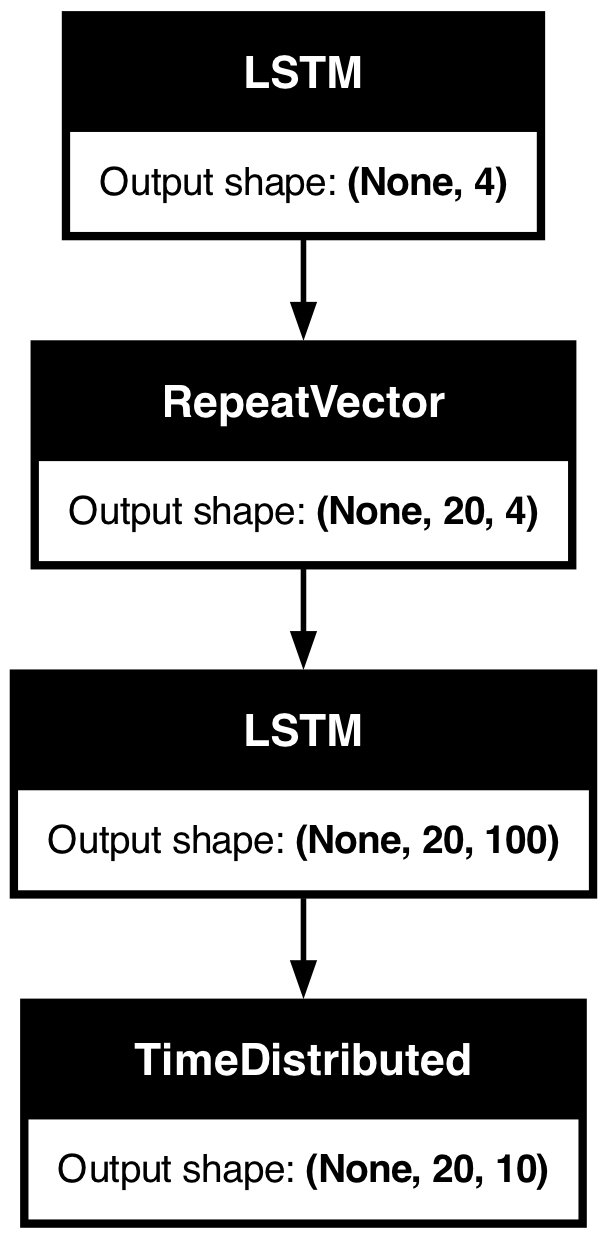

In [174]:
# fit model
model.fit(features_normalised, features_normalised, epochs=100, verbose=1)
plot_model(model, show_shapes=True, to_file='./results/reconstruct_lstm_autoencoder.png')

In [175]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 4)              │           240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_3 (RepeatVector)  │ (None, 20, 4)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 20, 100)        │        42,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 20, 10)         │         1,010 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 129,752 (506.85 KB)

 Trainable params: 43,250 (168.95 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 86,502 (337.90 KB)

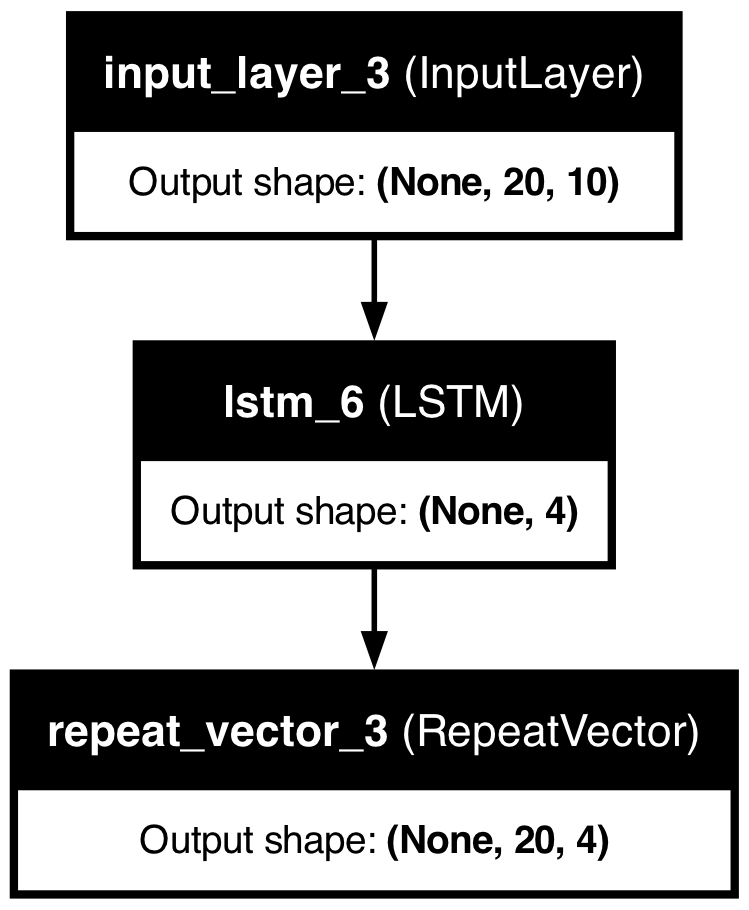

In [176]:
# connect the encoder LSTM as the output layer
model_feature = Model(inputs=model.inputs, outputs=model.layers[1].output)
plot_model(model_feature, show_shapes=True, show_layer_names=True, to_file='./results/lstm_encoder.png')

In [177]:
model_feature.summary()

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 20, 10)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 4)              │           240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_3 (RepeatVector)  │ (None, 20, 4)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 240 (960.00 B)

 Trainable params: 240 (960.00 B)

 Non-trainable params: 0 (0.00 B)

### 5.4 Get the Reconstructed Features

In [178]:
# get the feature vector for the input sequence
yhat = model_feature.predict(features_normalised)
print(yhat.shape)

117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step
(3730, 20, 4)


In [179]:
# reshape the vector
features_reduced = yhat.reshape(-1,4)

In [180]:
df.shape

(74600, 18)

In [181]:
features_reduced.shape

(74600, 4)

In [182]:
# Copy original data frame and drop the original features
df_reduced = df.copy()
df_reduced = df_reduced .drop(features_list, axis=1)

In [183]:
df_reduced.head()

,date,tic,close,high,low,open,volume,cov_list
0,2009-01-13,ASIANPAINT.NS,91.699997,88.500000,91.235001,88.500000,65800,"[[0.0005821350723573744, 0.0001385649017777150..."
1,2009-01-13,CIPLA.NS,189.649994,184.000000,185.350006,185.000000,901712,"[[0.0005821350723573744, 0.0001385649017777150..."
2,2009-01-13,DRREDDY.NS,478.000000,448.000000,452.750000,465.750000,544994,"[[0.0005821350723573744, 0.0001385649017777150..."
3,2009-01-13,GAIL.NS,39.375019,37.875019,38.756268,38.606270,9334277,"[[0.0005821350723573744, 0.0001385649017777150..."
4,2009-01-13,GRASIM.NS,209.852203,202.908554,204.891357,205.570282,1994905,"[[0.0005821350723573744, 0.0001385649017777150..."


In [184]:
# convert the reduced features to a data frame and merge with the original data frame
features_reduced_df = pd.DataFrame(features_reduced, columns=['f01','f02','f03','f04'])

In [185]:
features_reduced_df.head()

,f01,f02,f03,f04
0,0.646335,0.708096,0.085455,2.997396
1,0.646335,0.708096,0.085455,2.997396
2,0.646335,0.708096,0.085455,2.997396
3,0.646335,0.708096,0.085455,2.997396
4,0.646335,0.708096,0.085455,2.997396


In [186]:
df_reduced[['f01','f02','f03','f04']] = features_reduced_df[['f01','f02','f03','f04']]

In [187]:
df_reduced

,date,tic,close,high,low,open,volume,cov_list,f01,f02,f03,f04
0,2009-01-13,ASIANPAINT.NS,91.699997,88.500000,91.235001,88.500000,65800,"[[0.0005821350723573744, 0.0001385649017777150...",0.646335,0.708096,0.085455,2.997396
1,2009-01-13,CIPLA.NS,189.649994,184.000000,185.350006,185.000000,901712,"[[0.0005821350723573744, 0.0001385649017777150...",0.646335,0.708096,0.085455,2.997396
2,2009-01-13,DRREDDY.NS,478.000000,448.000000,452.750000,465.750000,544994,"[[0.0005821350723573744, 0.0001385649017777150...",0.646335,0.708096,0.085455,2.997396
3,2009-01-13,GAIL.NS,39.375019,37.875019,38.756268,38.606270,9334277,"[[0.0005821350723573744, 0.0001385649017777150...",0.646335,0.708096,0.085455,2.997396
4,2009-01-13,GRASIM.NS,209.852203,202.908554,204.891357,205.570282,1994905,"[[0.0005821350723573744, 0.0001385649017777150...",0.646335,0.708096,0.085455,2.997396
...,...,...,...,...,...,...,...,...,...,...,...,...
74595,2024-02-28,RELIANCE.NS,2982.550049,2900.350098,2911.250000,2966.000000,4323975,"[[9.859783653953769e-05, -1.0827919874351947e-...",1.237136,1.160065,3.139855,3.094981
74596,2024-02-28,SBIN.NS,756.750000,741.000000,742.500000,749.849976,11263318,"[[9.859783653953769e-05, -1.0827919874351947e-...",1.237136,1.160065,3.139855,3.094981
74597,2024-02-28,SUNPHARMA.NS,1587.449951,1562.650024,1573.849976,1586.500000,578316,"[[9.859783653953769e-05, -1.0827919874351947e-...",1.237136,1.160065,3.139855,3.094981
74598,2024-02-28,TCS.NS,4154.899902,4089.000000,4118.950195,4095.600098,1939225,"[[9.859783653953769e-05, -1.0827919874351947e-...",1.237136,1.160065,3.139855,3.094981


In [188]:
data_df = df_reduced.copy()

In [189]:
%store data_df

Stored 'data_df' (DataFrame)


In [190]:
# Check for missing values in the DataFrame after feature reduction
missing_values = df_reduced.isnull().sum()
print("Missing values after feature reduction:\n", missing_values)


Missing values after feature reduction:
 date        0
tic         0
close       0
high        0
low         0
open        0
volume      0
cov_list    0
f01         0
f02         0
f03         0
f04         0
dtype: int64


In [191]:
# Summary statistics of original features
original_features_summary = features_df.describe()

# Summary statistics of reduced features
reduced_features_summary = features_reduced_df.describe()

print("Summary statistics of original features:\n", original_features_summary)
print("\nSummary statistics of reduced features:\n", reduced_features_summary)


Summary statistics of original features:
                 atr           bbw           obv           cmf          macd  \
count  74600.000000  74600.000000  7.460000e+04  74600.000000  74600.000000   
mean      25.806703     10.964878  1.720917e+10     -5.664056      4.202458   
std       36.011353      6.575257  1.188765e+10      1.942654     32.233325   
min        0.671089      1.267602 -8.752229e+07    -36.697901   -557.631883   
25%        5.586614      6.623770  3.157494e+09     -6.601216     -2.864992   
50%       12.436345      9.424698  1.893738e+10     -5.332098      1.237041   
75%       31.207940     13.336876  2.605174e+10     -4.332058      8.712283   
max      547.209021     73.872203  3.977656e+10     -1.911441    369.755924   

                adx           sma           ema           cci           rsi  
count  74600.000000  74600.000000  74600.000000  74600.000000  74600.000000  
mean      21.928312   1083.592122   1083.608930     15.472947     52.599936  
std        8

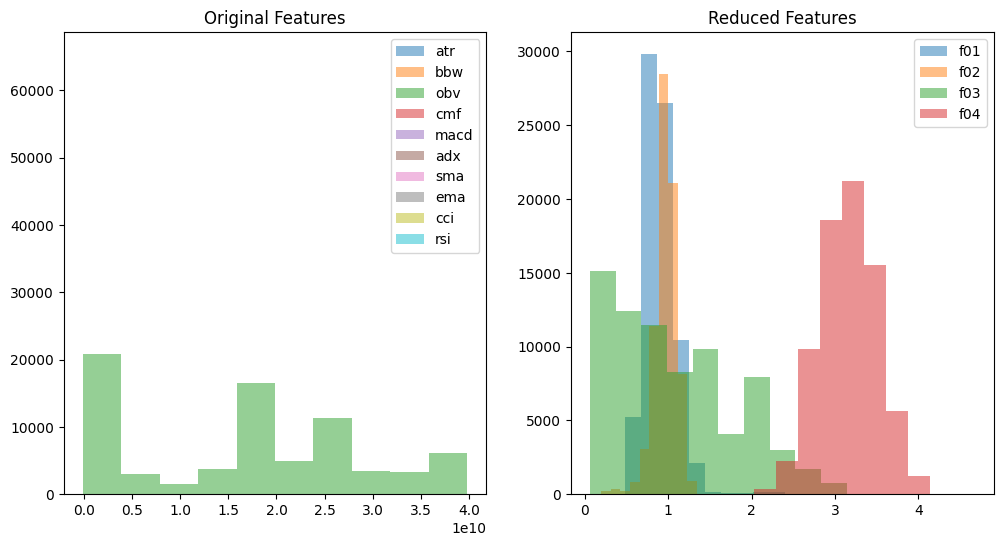

In [192]:
import matplotlib.pyplot as plt

# Visualize original and reduced features
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot original features
for i, feature in enumerate(features_list):
    axs[0].hist(features_df[feature], alpha=0.5, label=feature)
axs[0].set_title('Original Features')
axs[0].legend()

# Plot reduced features
for i, column in enumerate(features_reduced_df.columns):
    axs[1].hist(features_reduced_df[column], alpha=0.5, label=column)
axs[1].set_title('Reduced Features')
axs[1].legend()

plt.show()
